In [ ]:
#! pip install gym[box2d]
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import matplotlib.pyplot as plt
import numpy as np
import gym

In [ ]:
max_episodes = 500
gamma = 0.99
n_trials = 25
timestep = 10
ppo_steps = 5
epsilon_clip = 0.2
learning_rate = 0.0005

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        dropout = 0.1
        self.net = nn.Sequential(
            nn.Linear(8, 128),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(128, 128),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [ ]:
actor = PolicyNetwork(4)
critic = PolicyNetwork(1)

policy = ActorCritic(actor, critic)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)


In [ ]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
optimizer = optim.Adam(policy.parameters(), lr = learning_rate)

In [ ]:
def train(env, policy, optimizer, discount_factor, ppo_steps, epsilon_clip):
        
    policy.train()
        
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    returns = []
    R = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_pred, value_pred = policy(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
    
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / returns.std()
    advantages = returns - values    
    advantages = (advantages - advantages.mean()) / advantages.std()

    total_policy_loss = 0 
    total_value_loss = 0
    
    states = states.detach()
    actions = actions.detach()
    log_prob_actions = log_prob_actions.detach()
    advantages = advantages.detach()
    returns = returns.detach()
    
    for _ in range(ppo_steps):
                
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - epsilon_clip, max = 1.0 + epsilon_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).mean()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()

    policy_loss, value_loss = total_policy_loss / ppo_steps, total_value_loss / ppo_steps

   

    return policy_loss, value_loss, episode_reward

In [ ]:

def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [ ]:

rewards_per_episode = []
env = gym.make('LunarLander-v2')
def main():
  for episode in range(1, max_episodes+1):
      
      policy_loss, value_loss, train_reward = train(env, policy, optimizer, gamma, ppo_steps, epsilon_clip)     
      rewards_per_episode.append(train_reward)
      mean_rewards_per_episode = np.mean(rewards_per_episode[-n_trials:])
      
      if episode % timestep == 0:
          
          print(f'| Episode: {episode:3} | Average Rewards: {mean_rewards_per_episode:7.1f} ')

  env.close()

if __name__ == '__main__':
    main()


| Episode:  10 | Average Rewards:  -257.8 
| Episode:  20 | Average Rewards:  -273.1 
| Episode:  30 | Average Rewards:  -321.0 
| Episode:  40 | Average Rewards:  -341.8 
| Episode:  50 | Average Rewards:  -302.0 
| Episode:  60 | Average Rewards:  -227.0 
| Episode:  70 | Average Rewards:  -195.9 
| Episode:  80 | Average Rewards:  -189.8 
| Episode:  90 | Average Rewards:  -201.7 
| Episode: 100 | Average Rewards:  -259.0 
| Episode: 110 | Average Rewards:  -263.4 
| Episode: 120 | Average Rewards:  -317.4 
| Episode: 130 | Average Rewards:  -409.0 
| Episode: 140 | Average Rewards:  -458.6 
| Episode: 150 | Average Rewards:  -326.8 
| Episode: 160 | Average Rewards:  -320.1 
| Episode: 170 | Average Rewards:  -266.2 
| Episode: 180 | Average Rewards:  -246.5 
| Episode: 190 | Average Rewards:  -156.0 
| Episode: 200 | Average Rewards:   -80.7 
| Episode: 210 | Average Rewards:   -32.1 
| Episode: 220 | Average Rewards:   -14.8 
| Episode: 230 | Average Rewards:   -21.5 
| Episode: 

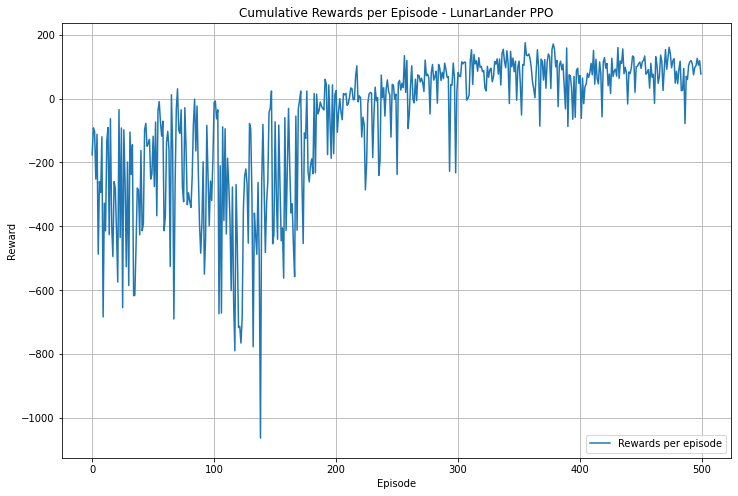

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(rewards_per_episode, label='Rewards per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Cumulative Rewards per Episode - LunarLander PPO")
plt.legend(loc='lower right')
plt.grid()